In [21]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from torch_geometric.data import Batch
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    include_hydrogen=include_hydrogen,
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 128
train_loader = DataLoader(train_dataset[:batch_size], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_batch = next(iter(train_loader))
train_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DataBatch(x=[1127, 4], edge_index=[2, 2404], edge_attr=[2404, 4], y=[128, 19], pos=[2327, 3], z=[2327], smiles=[128], name=[128], idx=[128], edge_index_full=[2, 4414], edge_attr_full=[4414, 5], batch=[1127], ptr=[129])

In [ ]:
fig, axs = plt.subplots(1, batch_size, figsize=(batch_size * 3, 3))
if batch_size > 1:
    axs = axs.flatten()

for i in range(len(train_batch)):
    batch_mask = train_batch.batch == i
    
    graph = train_batch[i]
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if batch_size > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")

plt.tight_layout()
plt.show()

# Decoder

In [35]:
num_clusters = 16
hparams = {
    "include_hydrogen": include_hydrogen,
    "eta_dim": 128,
    "num_clusters": num_clusters,
    "z_dim": 8,
    "num_atom_types": dataset.num_node_features,
    "num_bond_types": dataset.num_edge_features,
    "eta_kl_weight": 1.0,
    "c_kl_weight": 1.0,
    "z_kl_weight": 0.1,
    "cluster_mlp_hidden_dim": 128,
    "bond_type_mlp_hidden_dim": 128,
}

if hparams["cluster_mlp_hidden_dim"] == 0 and hparams["eta_dim"] != hparams["num_clusters"]:
    raise ValueError(f'eta_dim ({hparams["eta_dim"]}) must equal num_cluster ({hparams["num_clusters"]}) when cluster_mlp_hidden_dim > 0')

print(hparams)

{'include_hydrogen': False, 'eta_dim': 128, 'num_clusters': 16, 'z_dim': 8, 'num_atom_types': 4, 'num_bond_types': 4, 'eta_kl_weight': 1.0, 'c_kl_weight': 1.0, 'z_kl_weight': 1.0, 'cluster_mlp_hidden_dim': 128, 'bond_type_mlp_hidden_dim': 128}


# Training

In [36]:
import torch.nn.functional as F
import torch.distributions as D
from torch_geometric.utils import scatter

from mixture_model.encoder import MixtureModelEncoder
from mixture_model.decoder import MixtureModelDecoder


def kl_divergence_gaussian(mu_q, sigma_q, mu_p, sigma_p):
    """
    KL(q||p)
    """
    epsilon = 1e-6
    sigma_q = torch.clamp(sigma_q, min=epsilon)
    sigma_p = torch.clamp(sigma_p, min=epsilon)
    return (torch.log(sigma_p / sigma_q) + ((sigma_q ** 2 + (mu_q - mu_p) ** 2)) / (2 * (sigma_p ** 2)) - 0.5).sum(dim=1)


def kl_divergence_categorical(pi_q, pi_p):
    """
    KL(q||p)
    """
    epsilon = 1e-6
    pi_q = torch.clamp(pi_q, min=epsilon)
    pi_p = torch.clamp(pi_p, min=epsilon)
    return (pi_q * torch.log(pi_q / pi_p)).sum(dim=1)


encoder_model = MixtureModelEncoder(hparams=hparams).to(device)
decoder_model = MixtureModelDecoder(hparams=hparams).to(device)


epochs = 1000
optimizer = torch.optim.Adam(params=list(encoder_model.parameters()) + list(decoder_model.parameters()), lr=1e-3, weight_decay=1e-6)

encoder_model.train()
decoder_model.train()

decoder_model.set_gumbel_softmax_temperature(temperature=1.0)
N = 500
r = 1e-4

loss_vals = []

for epoch in tqdm(range(epochs)):

    for batch_index, train_batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} Training")):

        iteration = len(train_loader) * epoch + batch_index

        if (iteration + 1) % N == 0:
            tau = max(0.5, math.exp(-r * iteration))
            decoder_model.set_gumbel_softmax_temperature(tau)

        optimizer.zero_grad()

        train_z_mu, train_z_sigma, train_eta_mu, train_eta_sigma = encoder_model(train_batch)
        train_z = torch.randn_like(train_z_mu) * train_z_sigma + train_z_mu
        train_num_atoms = torch.bincount(train_batch.batch)
        train_reconstruction = decoder_model.decode_z(train_z, train_num_atoms)
        train_target_x = torch.argmax(train_batch.x, dim=1)

        # atom reconstruction loss
        loss = F.cross_entropy(input=train_reconstruction.x, target=train_target_x, reduction="sum")
        
        # bond reconstruction loss
        train_target_edge_attr = torch.argmax(train_batch.edge_attr_full, dim=1)
        loss += F.cross_entropy(
            input=train_reconstruction.edge_attr,
            target=train_target_edge_attr,
            reduction="sum",
        )
        loss /= len(train_batch)

        # eta KL-Divergence
        eta_kl_divergence = kl_divergence_gaussian(
            mu_q=train_eta_mu,
            sigma_q=train_eta_sigma,
            mu_p=decoder_model.eta_mu,
            sigma_p=torch.exp(torch.clamp(decoder_model.eta_log_sigma, -20, 30))
        ).mean()  # mean over batch
        loss += eta_kl_divergence

        # cluster KL-Divergence
        train_eta = torch.randn_like(train_eta_mu) * train_eta_sigma + train_eta_mu
        train_pi_p = decoder_model.decode_eta(train_eta)
        train_pi_p = torch.repeat_interleave(train_pi_p, train_num_atoms, dim=0)
        train_z_log_likelihoods = D.Normal(
            loc=decoder_model.cluster_means, 
            scale=torch.exp(torch.clamp(decoder_model.cluster_log_sigmas, -20, 30))
        ).log_prob(train_z.unsqueeze(1)).sum(dim=2)
        train_weighted_z_log_likelihood = train_z_log_likelihoods + torch.log(train_pi_p)
        train_z_log_responsibilities = train_weighted_z_log_likelihood - torch.logsumexp(train_weighted_z_log_likelihood, dim=1, keepdim=True)
        train_pi_q = torch.exp(train_z_log_responsibilities)
        cluster_kl_divergence = kl_divergence_categorical(
            pi_q=train_pi_q,
            pi_p=train_pi_p,
        )
        # sum over all atoms in each molecule
        cluster_kl_divergence = scatter(cluster_kl_divergence, train_batch.batch, dim=0, reduce='sum')
        # mean over batches
        cluster_kl_divergence = cluster_kl_divergence.mean()
        loss += cluster_kl_divergence

        # z KL-Divergence
        sigma_pc = torch.exp(torch.clamp(decoder_model.cluster_log_sigmas, -20, 30))
        z_kl_divergence = kl_divergence_gaussian(
            mu_q=train_z_mu.unsqueeze(-1),
            sigma_q=train_z_sigma.unsqueeze(-1),
            mu_p=decoder_model.cluster_means.transpose(1, 2),
            sigma_p=sigma_pc.transpose(1, 2)
        )
        z_kl_divergence = (z_kl_divergence * train_pi_q).sum(dim=1)
        # sum over all nodes in each molecule and average over batch
        z_kl_divergence = scatter(z_kl_divergence, train_batch.batch, dim=0, reduce='sum').mean()
        loss += z_kl_divergence * hparams["z_kl_weight"]

        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())


encoder_model.eval()
decoder_model.eval()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [02:05<00:00,  7.96it/s]


MixtureModelDecoder(
  (cluster_mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=128, out_features=16, bias=True)
  )
  (atom_classifier): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
  (bond_type_mlp): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [37]:
loss_vals[-1]

37.02705383300781

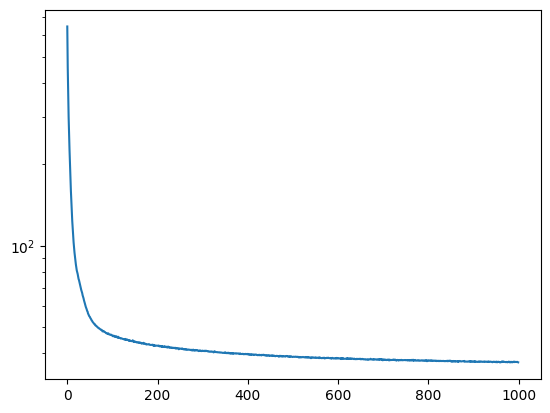

In [38]:
plt.plot(loss_vals)
plt.yscale("log")
plt.show()

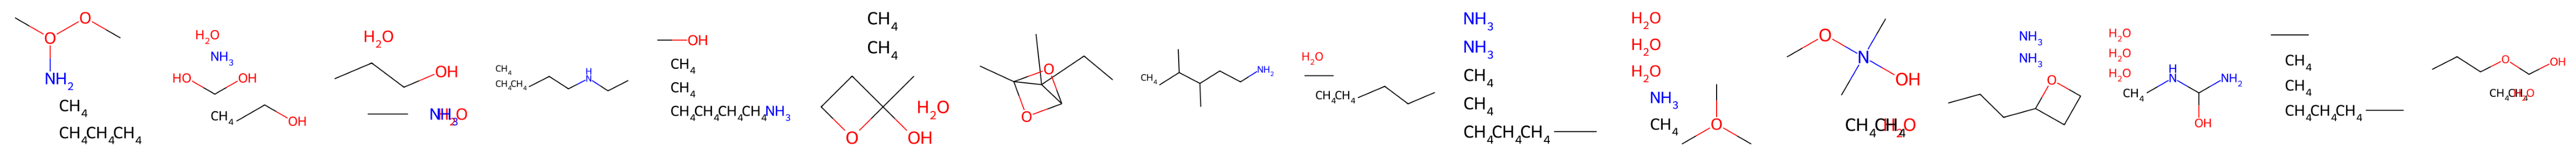

In [54]:
def get_batch_item(batch_data: Data, i: int):
    node_mask = batch_data.batch == i

    offsets = torch.cumsum(torch.bincount(batch_data.batch), dim=0)

    edge_mask = (batch_data.edge_index[0] < offsets[i]) & (batch_data.edge_index[1] < offsets[i])
    if i > 0:
        edge_mask &= (batch_data.edge_index[0] >= offsets[i - 1]) & (batch_data.edge_index[1] >= offsets[i - 1])

    # remove non-existent edges
    edge_mask &= batch_data.edge_attr.argmax(dim=1) < 4
    edge_attr = batch_data.edge_attr[edge_mask][:,:-1]

    # adjust edge index based on batch index
    edge_index = batch_data.edge_index[:, edge_mask]
    if i > 0:
        edge_index -= offsets[i - 1]

    return Data(
        x=batch_data.x[node_mask],
        edge_index=edge_index,
        edge_attr=edge_attr
    )


num_atoms = torch.tensor([9] * 16, dtype=torch.int64, device=device)
data = decoder_model.sample(num_atoms, device)

num_molecules = len(num_atoms)

fig, axs = plt.subplots(1, num_molecules, figsize=(num_molecules * 3, 3))
if num_molecules > 1:
    axs = axs.flatten()

for i in range(num_molecules):
    graph = get_batch_item(data, i)
    mol = graph_to_mol(data=graph, includes_h=include_hydrogen, validate=False)
    if num_molecules > 1:
        axis = axs[i]
    else:
        axis = axs
    axis.imshow(Draw.MolToImage(mol))
    axis.axis("off")


plt.tight_layout()
plt.show()